In [78]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [79]:
df = pd.read_csv("../1_datasets/final_datasets/final_merged_covid_pm25_sdi.csv")

In [80]:
df.head()

,Country,COVID_Deaths_Rate,upper,lower,Mean_PM25_2010_2019,Year,SDI_mean_value
0,Lao People's Democratic Republic,6.867837e-11,6.867837e-11,6.867837e-11,21.164,2020,0.484193
1,Sri Lanka,2.820345e+00,2.820345e+00,2.820345e+00,23.948,2020,0.697649
2,Fiji,8.084884e+00,1.685940e+01,2.008246e+00,7.272,2020,0.671431
3,Samoa,2.370317e-09,2.370317e-09,2.370317e-09,7.623,2020,0.590075
4,Malaysia,1.516114e+00,2.286782e+00,8.061217e-01,21.670,2020,0.738744


In [81]:
#  Random Forest Model
df["log_death_rate"] = np.log(df["COVID_Deaths_Rate"])

X = df[["Mean_PM25_2010_2019", "SDI_mean_value"]]
y = df["log_death_rate"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model Performance on Test Set:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


Model Performance on Test Set:
R²: 0.329
MAE: 2.788
RMSE: 5.183


In [83]:
# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance)

Feature Importance:
               Feature  Importance
0  Mean_PM25_2010_2019    0.536289
1       SDI_mean_value    0.463711


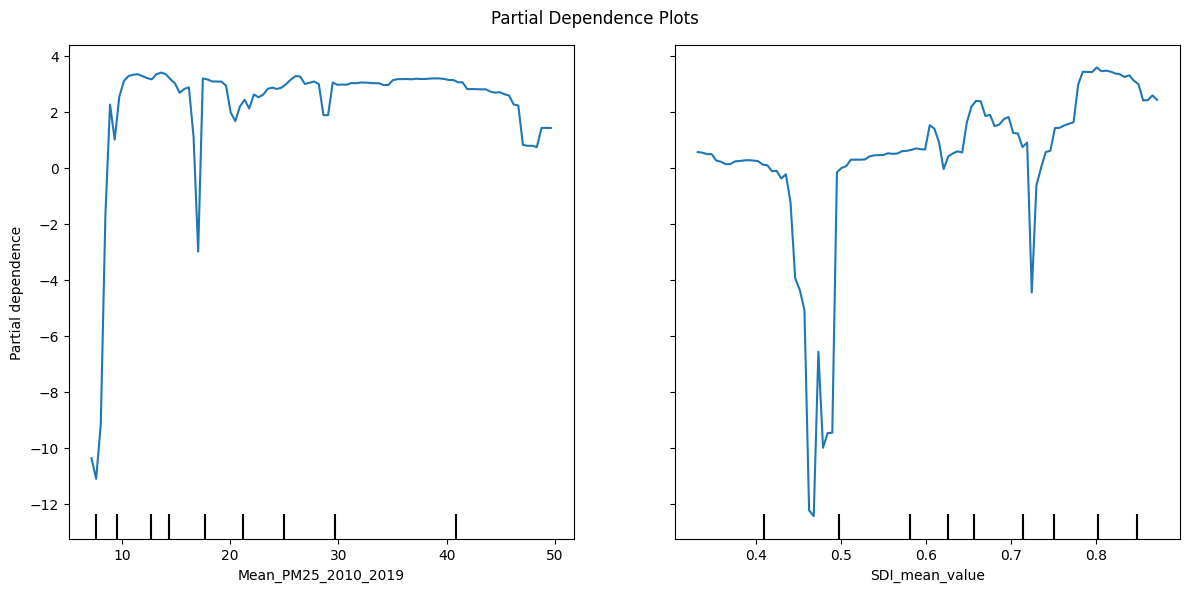

In [84]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(rf, X_train, ['Mean_PM25_2010_2019', 'SDI_mean_value'], ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.show()

In [85]:
# 4. Nonlinear Modeling with Splines
from patsy import dmatrix

df["log_death_rate"] = np.log(df["COVID_Deaths_Rate"] + 1)

# Generate spline basis for PM2.5 (3 knots)
pm25_spline = dmatrix(
    "bs(Mean_PM25_2010_2019, df=4, include_intercept=False)",
    {"Mean_PM25_2010_2019": df["Mean_PM25_2010_2019"]},
    return_type="dataframe",
)
# Combine with SDI
X = pd.concat([pm25_spline, df["SDI_mean_value"]], axis=1)
X = sm.add_constant(X)
y = df["log_death_rate"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     10.79
Date:                Sun, 13 Jul 2025   Prob (F-statistic):           4.10e-09
Time:                        16:41:44   Log-Likelihood:                -341.47
No. Observations:                 190   AIC:                             694.9
Df Residuals:                     184   BIC:                             714.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

X_pred columns: Index(['Intercept', 'bs(x, df=4, include_intercept=False)[0]',
       'bs(x, df=4, include_intercept=False)[1]',
       'bs(x, df=4, include_intercept=False)[2]',
       'bs(x, df=4, include_intercept=False)[3]', 'SDI_mean_value'],
      dtype='object')
Model params: Index(['Intercept',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[0]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[1]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[2]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[3]',
       'SDI_mean_value'],
      dtype='object')


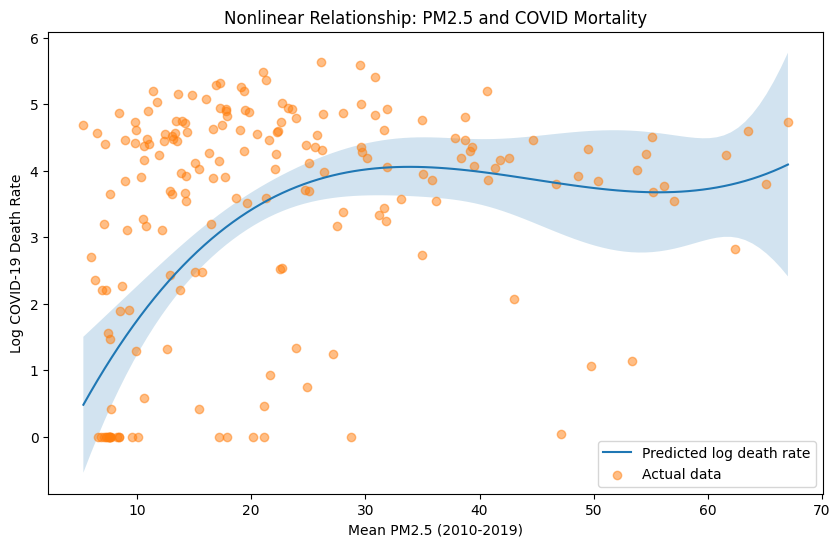

In [86]:
pm25_range = np.linspace(
    df["Mean_PM25_2010_2019"].min(), df["Mean_PM25_2010_2019"].max(), 100
)
pm25_spline = dmatrix(
    "bs(x, df=4, include_intercept=False)", {"x": pm25_range}, return_type="dataframe"
)

X_pred = pd.concat(
    [
        pm25_spline.reset_index(drop=True),
        pd.DataFrame(
            {"SDI_mean_value": df["SDI_mean_value"].median()}, index=range(100)
        ),
    ],
    axis=1,
)

print("X_pred columns:", X_pred.columns)
print("Model params:", model.params.index)

pred = model.get_prediction(X_pred)
pred_summary = pred.summary_frame(alpha=0.05)

pred_df = pd.DataFrame(
    {
        "PM25": pm25_range,
        "Predicted": pred_summary["mean"],
        "CI_low": pred_summary["mean_ci_lower"],
        "CI_high": pred_summary["mean_ci_upper"],
    }
)


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(pred_df["PM25"], pred_df["Predicted"], label="Predicted log death rate")
plt.fill_between(pred_df["PM25"], pred_df["CI_low"], pred_df["CI_high"], alpha=0.2)
plt.scatter(
    df["Mean_PM25_2010_2019"], df["log_death_rate"], alpha=0.5, label="Actual data"
)
plt.xlabel("Mean PM2.5 (2010-2019)")
plt.ylabel("Log COVID-19 Death Rate")
plt.title("Nonlinear Relationship: PM2.5 and COVID Mortality")
plt.legend()
plt.show()


In [87]:
# Model with interaction between PM2.5 splines and SDI
formula = """
log_death_rate ~ 
bs(Mean_PM25_2010_2019, df=4) * SDI_mean_value
"""
interaction_model = smf.ols(formula, data=df).fit()
print(interaction_model.summary())


                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     9.132
Date:                Sun, 13 Jul 2025   Prob (F-statistic):           2.42e-11
Time:                        16:41:47   Log-Likelihood:                -330.17
No. Observations:                 190   AIC:                             680.3
Df Residuals:                     180   BIC:                             712.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

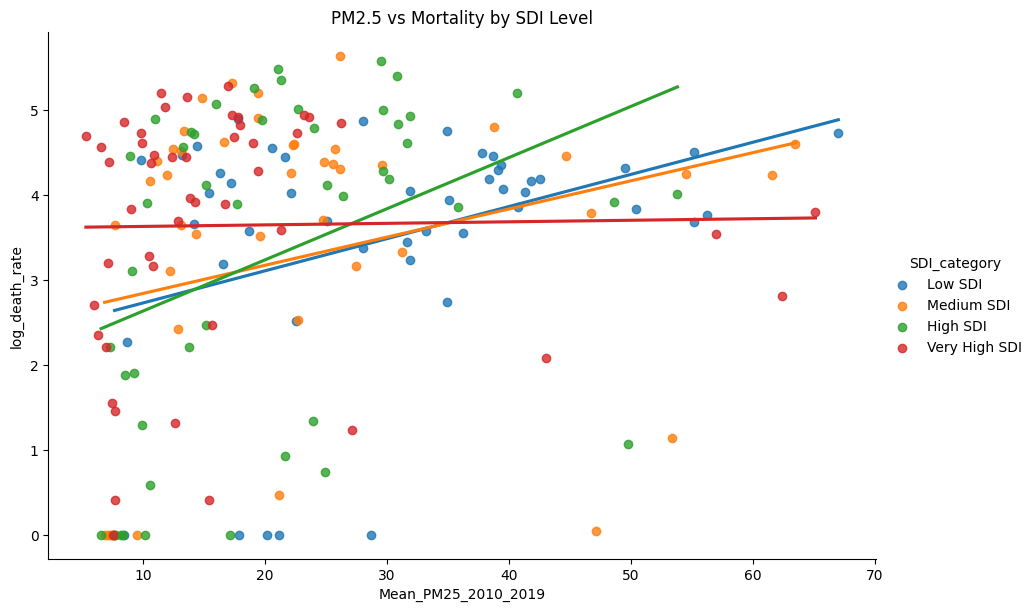

In [88]:
# Visualize interaction
# Create SDI category column in the DataFrame
df["SDI_category"] = pd.qcut(df["SDI_mean_value"], 4, labels=["Low SDI", "Medium SDI","High SDI", "Very High SDI"])

# Now plot using the new column name for hue
sns.lmplot(
    x="Mean_PM25_2010_2019",
    y="log_death_rate",
    hue="SDI_category",
    data=df,
    ci=None,
    height=6,
    aspect=1.5,
)

plt.title("PM2.5 vs Mortality by SDI Level")
plt.show()


In [89]:

from statsmodels.stats.outliers_influence import OLSInfluence

infl = OLSInfluence(model)

print("\nTop 5 Influential Points:")

# Get the indices of the top 5 largest Cook's distances
top5_idx = infl.cooks_distance[0].argsort()[-5:]

# Use loc to select rows by these indices
print(df.loc[top5_idx, ['Country', 'COVID_Deaths_Rate', 'Mean_PM25_2010_2019', 'SDI_mean_value']])



Top 5 Influential Points:
        Country  COVID_Deaths_Rate  Mean_PM25_2010_2019  SDI_mean_value
33        China           1.898881               49.782        0.713365
73       Sweden          95.284529                6.532        0.885062
17     Mongolia           0.040810               47.101        0.614630
97  Afghanistan         112.969944               67.013        0.329830
50      Bahamas         108.036867                5.306        0.802948


In [90]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [91]:
# Quantile regression for different parts of the outcome distribution
import statsmodels.regression.quantile_regression as qr

for quantile in [0.25, 0.5, 0.75]:
    q_model = qr.QuantReg(
        df["log_death_rate"],
        sm.add_constant(df[["Mean_PM25_2010_2019", "SDI_mean_value"]]),
    ).fit(q=quantile)
    print(f"\nQuantile {quantile} Results:")
    print(q_model.summary())



Quantile 0.25 Results:
                         QuantReg Regression Results                          
Dep. Variable:         log_death_rate   Pseudo R-squared:              0.08158
Model:                       QuantReg   Bandwidth:                       1.283
Method:                 Least Squares   Sparsity:                        6.555
Date:                Sun, 13 Jul 2025   No. Observations:                  190
Time:                        16:41:53   Df Residuals:                      187
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.4607      1.151      2.139      0.034       0.191       4.731
Mean_PM25_2010_2019     0.0404      0.019      2.117      0.036       0.003       0.078
SDI_mean_value         -1.3102      1.321     -0.992      0.323      -3